In [46]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import sklearn.linear_model as lm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Make the logistic Regression to get the search rates (no interaction term)

In [47]:
def compute_search_rates(df_, formula):
    
    df = df_.copy()
    # First we transform the datetime to ordinal values
    df.date = pd.to_datetime(df.date)
    df.date = df.date.map(dt.datetime.toordinal)

    # Standardize date
    date_mean = df.date.mean()
    date_std = df.date.std()
    df.date = (df.date - date_mean) / date_std

    # Make search_conducted be 0 or 1
    df.search_conducted =  df.search_conducted.astype(int)

    # Compute the search rates using a logistic regression

    model = smf.logit(formula = formula, data = df).fit()

    search_rates = model.predict()
    
    return search_rates, model

In [48]:
df = pd.read_csv('data.csv')

search_rates, _ = compute_search_rates(df, 'search_conducted ~ date + C(subject_race) + C(Partisanship) + C(subject_sex)')

# Append the search rates
df['search_rates'] = search_rates

# Drop search_conducted, we don't need anymore
df.drop('search_conducted', axis = 1, inplace = True)

Optimization terminated successfully.
         Current function value: 0.150392
         Iterations 8


In [49]:
df.head()

,date,subject_race,subject_sex,State,Partisanship,search_rates
0,2014-02-05,white,male,AZ,R,0.027264
1,2014-01-31,hispanic,male,AZ,R,0.046384
2,2014-02-02,white,female,AZ,R,0.016356
3,2014-05-25,hispanic,male,AZ,R,0.045369
4,2015-05-01,white,male,AZ,R,0.024938


In [50]:
df.to_csv('data_search_rates_no_interac.csv', index = False)

In [51]:
df = pd.read_csv('data_search_rates_no_interac.csv')

# Make the logistic Regression to get the search rates (with interaction term)

In [52]:
df = pd.read_csv('data.csv')

search_rates, _ = compute_search_rates(df, 'search_conducted ~ date + C(subject_race):C(Partisanship) + C(subject_sex)')

# Append the search rates
df['search_rates'] = search_rates

# Drop search_conducted, we don't need anymore
df.drop('search_conducted', axis = 1, inplace = True)

Optimization terminated successfully.
         Current function value: 0.150300
         Iterations 8


In [55]:
df.head()

,date,subject_race,subject_sex,State,Partisanship,search_rates
0,2014-02-05,white,male,AZ,R,0.028441
1,2014-01-31,hispanic,male,AZ,R,0.048639
2,2014-02-02,white,female,AZ,R,0.017085
3,2014-05-25,hispanic,male,AZ,R,0.047571
4,2015-05-01,white,male,AZ,R,0.026005


In [56]:
df.to_csv('data_search_rates_interac.csv', index = False)

# Biases with interaction term

In [ ]:
df = pd.read_csv('data_search_rates_interac.csv')

In [43]:
def bootstrap(df,n_boots=1000):
    
    relative_black = []
    relative_hispanic = []
    
    for n in range(n_boots):
        
        inds = np.random.randint(df.shape[0], size = (df.shape[0]))
        sample = df.iloc[inds]
        
        white_mean = sample[sample.subject_race == 'white']['search_rates'].mean()
        hispanic_mean = sample[sample.subject_race == 'hispanic']['search_rates'].mean()
        black_mean = sample[sample.subject_race == 'black']['search_rates'].mean()
        
        relative_black.append(black_mean/white_mean)
        relative_hispanic.append(hispanic_mean/white_mean)
        
    CI_black = [np.percentile(relative_black,2.5), np.percentile(relative_black, 97.5)]
    CI_hispanic = [np.percentile(relative_hispanic, 2.5), np.percentile(relative_hispanic, 97.5)]
    
    return CI_black, CI_hispanic

Compute the relative biases and confidence intervals

In [44]:
biases = pd.DataFrame([], columns = ['state', 'subject_race','relative_diff', 'CI'])

for state in States:
    
    df_state = df[df.State==state]
    
    black_mean = df_state[df_state.subject_race=='black']['search_rates'].mean()
    hispanic_mean = df_state[df_state.subject_race=='hispanic']['search_rates'].mean()
    white_mean = df_state[df_state.subject_race=='white']['search_rates'].mean()
    
    relative_diff_black = black_mean/white_mean
    relative_diff_hispanic = hispanic_mean/white_mean
    
    CI_black, CI_hispanic = bootstrap(df_state)
    
    df_black = pd.DataFrame([[state, 'black', relative_diff_black, CI_black]], columns = ['state', 'subject_race','relative_diff', 'CI'])
    biases = pd.concat((biases, df_black))
    df_hispanic = pd.DataFrame([[state, 'hispanic', relative_diff_hispanic, CI_hispanic]], columns = ['state', 'subject_race','relative_diff', 'CI'])
    biases = pd.concat((biases, df_hispanic))
    
    print('State: {} over.'.format(state))

State: AZ over.
State: SC over.
State: TX over.
State: CA over.
State: CT over.
State: IL over.


In [45]:
biases.to_csv('biases_interac.csv', index = False)

In [46]:
biases

,state,subject_race,relative_diff,CI
0,AZ,black,1.597026,"[1.591955955398065, 1.6017058058517164]"
0,AZ,hispanic,1.754986,"[1.7519431138572046, 1.7578577876988242]"
0,SC,black,1.553272,"[1.5504996295188096, 1.5559987154761608]"
0,SC,hispanic,1.814590,"[1.8085287804103758, 1.8207836299846443]"
0,TX,black,1.583151,"[1.578956359311796, 1.5874995417643034]"
0,TX,hispanic,1.745863,"[1.7429431482867364, 1.7487734732299058]"
0,CA,black,2.169497,"[2.1637206733522656, 2.175249412476498]"
0,CA,hispanic,1.732018,"[1.72926238698631, 1.7348436144193453]"
0,CT,black,2.227593,"[2.222741043582298, 2.2329035290281194]"
0,CT,hispanic,1.731416,"[1.7274246159192794, 1.7357775373087905]"


In [47]:
black = biases[biases.subject_race=='black']
hispanic = biases[biases.subject_race=='hispanic']

Text(0.5, 1.0, 'Hispanic')

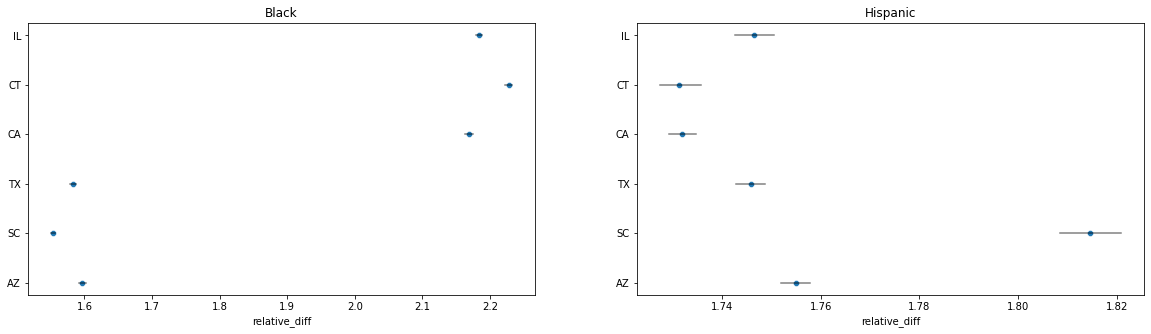

In [48]:
fig, axs = plt.subplots(1,2, figsize = (20,5))

sns.scatterplot(data = black, x = 'relative_diff', y = range(6), ax = axs[0])
for i in range(6):
    axs[0].plot([black.CI.iloc[i][0], black.CI.iloc[i][1]], [i,i], alpha = 0.5, color = 'k')
axs[0].set_yticks(range(6))
axs[0].set_yticklabels(States)
axs[0].set_title('Black')

sns.scatterplot(data = hispanic, x = 'relative_diff', y = range(6), ax = axs[1])
for i in range(6):
    axs[1].plot([hispanic.CI.iloc[i][0], hispanic.CI.iloc[i][1]], [i,i], alpha = 0.5, color = 'k')
axs[1].set_yticks(range(6)) 
axs[1].set_yticklabels(States)
axs[1].set_title('Hispanic')

# Biases without interaction term

In [35]:
df = pd.read_csv('data_search_rates_no_interac.csv')

In [36]:
def bootstrap(df,n_boots=1000):
    
    relative_black = []
    relative_hispanic = []
    
    for n in range(n_boots):
        
        inds = np.random.randint(df.shape[0], size = (df.shape[0]))
        sample = df.iloc[inds]
        
        white_mean = sample[sample.subject_race == 'white']['search_rates'].mean()
        hispanic_mean = sample[sample.subject_race == 'hispanic']['search_rates'].mean()
        black_mean = sample[sample.subject_race == 'black']['search_rates'].mean()
        
        relative_black.append(black_mean/white_mean)
        relative_hispanic.append(hispanic_mean/white_mean)
        
    CI_black = [np.percentile(relative_black,2.5), np.percentile(relative_black, 97.5)]
    CI_hispanic = [np.percentile(relative_hispanic, 2.5), np.percentile(relative_hispanic, 97.5)]
    
    return CI_black, CI_hispanic

Compute the relative biases and confidence intervals

In [37]:
biases = pd.DataFrame([], columns = ['state', 'subject_race','relative_diff', 'CI'])

for state in States:
    
    df_state = df[df.State==state]
    
    black_mean = df_state[df_state.subject_race=='black']['search_rates'].mean()
    hispanic_mean = df_state[df_state.subject_race=='hispanic']['search_rates'].mean()
    white_mean = df_state[df_state.subject_race=='white']['search_rates'].mean()
    
    relative_diff_black = black_mean/white_mean
    relative_diff_hispanic = hispanic_mean/white_mean
    
    CI_black, CI_hispanic = bootstrap(df_state)
    
    df_black = pd.DataFrame([[state, 'black', relative_diff_black, CI_black]], columns = ['state', 'subject_race','relative_diff', 'CI'])
    biases = pd.concat((biases, df_black))
    df_hispanic = pd.DataFrame([[state, 'hispanic', relative_diff_hispanic, CI_hispanic]], columns = ['state', 'subject_race','relative_diff', 'CI'])
    biases = pd.concat((biases, df_hispanic))
    
    print('State: {} over.'.format(state))

State: AZ over.
State: SC over.
State: TX over.
State: CA over.
State: CT over.
State: IL over.


In [38]:
biases.to_csv('biases_no_interac.csv', index = False)

In [39]:
biases

,state,subject_race,relative_diff,CI
0,AZ,black,1.937162,"[1.9313695233882777, 1.942932851118813]"
0,AZ,hispanic,1.745773,"[1.7430739930969334, 1.7487209594142017]"
0,SC,black,1.884378,"[1.8812148073468788, 1.8874288001402189]"
0,SC,hispanic,1.805241,"[1.7996460270973562, 1.8111376040918425]"
0,TX,black,1.920475,"[1.9152393120934115, 1.9257210688671733]"
0,TX,hispanic,1.736714,"[1.73401814428349, 1.7396108249156126]"
0,CA,black,1.883365,"[1.8782070416505676, 1.8884897711542186]"
0,CA,hispanic,1.747579,"[1.7449510382835394, 1.750468575098264]"
0,CT,black,1.933837,"[1.9295001889112067, 1.9383586775322368]"
0,CT,hispanic,1.747025,"[1.7429202095170186, 1.7510792768811374]"


In [40]:
black = biases[biases.subject_race=='black']
hispanic = biases[biases.subject_race=='hispanic']

Text(0.5, 1.0, 'Hispanic')

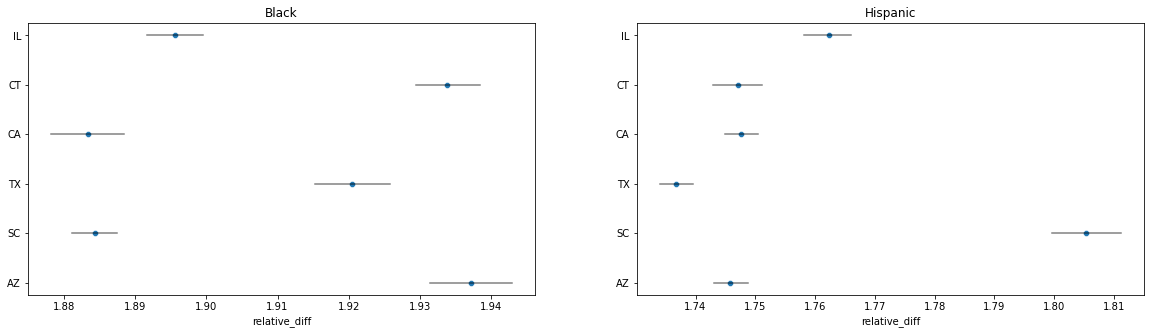

In [41]:
fig, axs = plt.subplots(1,2, figsize = (20,5))

sns.scatterplot(data = black, x = 'relative_diff', y = range(6), ax = axs[0])
for i in range(6):
    axs[0].plot([black.CI.iloc[i][0], black.CI.iloc[i][1]], [i,i], alpha = 0.5, color = 'k')
axs[0].set_yticks(range(6))
axs[0].set_yticklabels(States)
axs[0].set_title('Black')

sns.scatterplot(data = hispanic, x = 'relative_diff', y = range(6), ax = axs[1])
for i in range(6):
    axs[1].plot([hispanic.CI.iloc[i][0], hispanic.CI.iloc[i][1]], [i,i], alpha = 0.5, color = 'k')
axs[1].set_yticks(range(6)) 
axs[1].set_yticklabels(States)
axs[1].set_title('Hispanic')